In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import numpy as np
import matplotlib.pyplot as plt

# 1. Setup Data and Subset (1,000 samples per class = 10,000 total)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)) # Standard MNIST mean/std
])

full_train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Helper to get 1,000 indices per class
def get_balanced_subset_indices(dataset, samples_per_class=1000):
    indices = []
    counts = {i: 0 for i in range(10)}
    for idx, (_, label) in enumerate(dataset):
        if counts[label] < samples_per_class:
            indices.append(idx)
            counts[label] += 1
        if len(indices) == samples_per_class * 10:
            break
    return indices

train_indices = get_balanced_subset_indices(full_train_dataset)
train_subset = Subset(full_train_dataset, train_indices)

train_loader = DataLoader(train_subset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

# 2. Define the Shallow Neural Network
class ShallowNet(nn.Module):
    def __init__(self, k, dropout_p):
        super(ShallowNet, self).__init__()
        self.fc1 = nn.Linear(784, k)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_p)
        self.fc2 = nn.Linear(k, 10)

        # He Initialization
        nn.init.kaiming_normal_(self.fc1.weight, mode='fan_in', nonlinearity='relu')
        nn.init.zeros_(self.fc1.bias)

    def forward(self, x):
        x = x.view(-1, 784) # Flatten image
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# 3. Parameters for Experiment
k_values = [32, 512, 2048] # Widths (Under- to Overparameterized)
p_values = [0.0, 0.5]      # Dropout rates (None vs. Standard)
epochs = 10

# 4. Nested Loops for Automatic Training
results = {}

for k in k_values:
    for p in p_values:
        print(f"--- Training Model: k={k}, p={p} ---")

        model = ShallowNet(k, p)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)

        for epoch in range(epochs):
            model.train()
            for images, labels in train_loader:
                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()


        model.eval()
        correct = 0
        with torch.no_grad():
            for images, labels in test_loader:
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / len(test_dataset)
        results[(k, p)] = accuracy
        print(f"Final Test Accuracy: {accuracy}% \n")

print("All experiments complete.")

100%|██████████| 9.91M/9.91M [00:00<00:00, 43.8MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.19MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 10.8MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 2.58MB/s]


--- Training Model: k=32, p=0.0 ---
Final Test Accuracy: 93.35% 

--- Training Model: k=32, p=0.5 ---
Final Test Accuracy: 91.98% 

--- Training Model: k=512, p=0.0 ---
Final Test Accuracy: 96.32% 

--- Training Model: k=512, p=0.5 ---
Final Test Accuracy: 95.98% 

--- Training Model: k=2048, p=0.0 ---
Final Test Accuracy: 96.63% 

--- Training Model: k=2048, p=0.5 ---
Final Test Accuracy: 95.95% 

All experiments complete.


2. (7 pts) Pick the width grid K= [1, 5, 15, 35] and dropout grid P= [0.1, 0.25, 0.5, 1.0]. Run MNIST
models over these grids with Adam optimizer for 80 epochs. Store the test/train accuracy and loss.


• Fix p=1.0 which is the case of “no dropout regularization”. Plot the test and training accuracy
as a function of k. As k increases, does the performance improve? At what k, training accuracy
becomes 100%?


• Plot the training accuracy as a function of k and for different p ∈P on the same plot. What is the
role of p on training accuracy? When p is smaller, is it easier to optimize or more difficult? For
each choice of p, determine at what choice of k, training accuracy becomes 100%.


• Plot the test accuracy as a function of k and for different p ∈P on the same plot. Does dropout

In [ ]:
class ExperimentClassifier(nn.Module):
    def __init__(self, k, torch_dropout):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(784, k),
            nn.ReLU(),
            nn.Dropout(p=torch_dropout),
            nn.Linear(k, 10)
        )
        # He Initialization for the first layer
        nn.init.kaiming_normal_(self.network[0].weight, nonlinearity='relu')

    def forward(self, x):
        # Flatten the image: (batch, 1, 28, 28) -> (batch, 784)
        x = x.view(x.size(0), -1)
        return self.network(x)


K_grid = [1, 5, 15, 35]
P_grid = [0.1, 0.25, 0.5, 1.0]
EPOCHS = 80

# Storage for plotting
# Structure: {(k, p): {'train_acc': [], 'test_acc': [], 'train_loss': []}}
history = {}

for k in K_grid:
    for p_val in P_grid:
        print(f"Training k={k}, p={p_val}...")

        # Adjusting for "p as keep probability":
        torch_p = 1.0 - p_val

        model = ExperimentClassifier(k, torch_p)
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        criterion = nn.CrossEntropyLoss()

        k_p_results = {'train_acc': 0, 'test_acc': 0}

        for epoch in range(EPOCHS):
            model.train()
            correct_train = 0
            total_train = 0
            for images, labels in train_loader:
                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                # Track training accuracy for the final epoch
                if epoch == EPOCHS - 1:
                    _, predicted = torch.max(outputs.data, 1)
                    total_train += labels.size(0)
                    correct_train += (predicted == labels).sum().item()

        # Final Evaluation after 80 epochs
        model.eval()
        correct_test = 0
        with torch.no_grad():
            for images, labels in test_loader:
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                correct_test += (predicted == labels).sum().item()

        history[(k, p_val)] = {
            'train_acc': 100 * correct_train / total_train,
            'test_acc': 100 * correct_test / 10000
        }



Training k=1, p=0.1...
Training k=1, p=0.25...
Training k=1, p=0.5...
Training k=1, p=1.0...
Training k=5, p=0.1...
Training k=5, p=0.25...
Training k=5, p=0.5...
Training k=5, p=1.0...
Training k=15, p=0.1...
Training k=15, p=0.25...
Training k=15, p=0.5...
Training k=15, p=1.0...
Training k=35, p=0.1...
Training k=35, p=0.25...
Training k=35, p=0.5...
Training k=35, p=1.0...


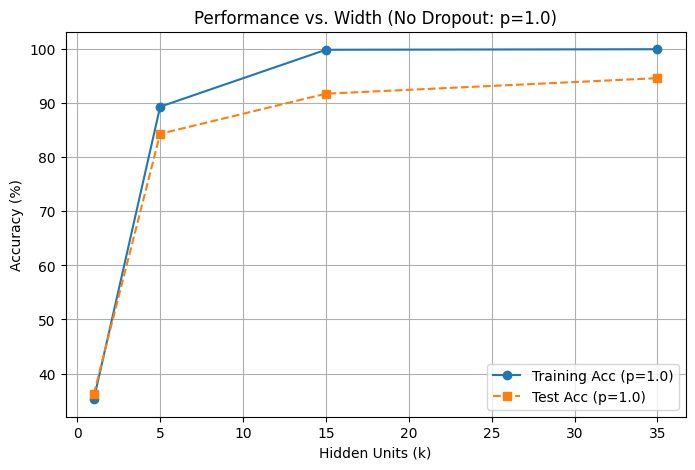

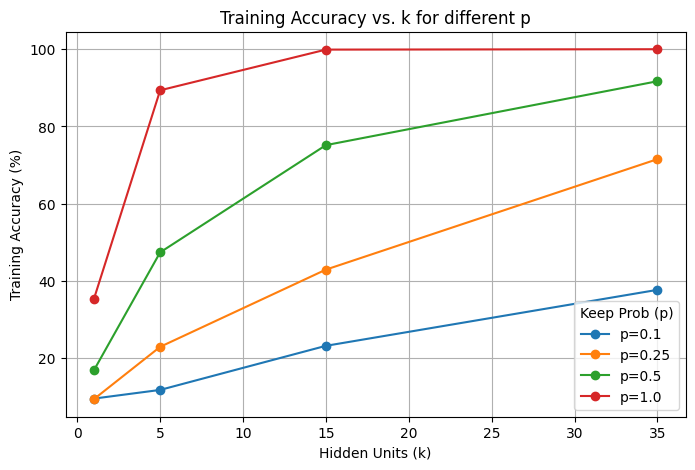

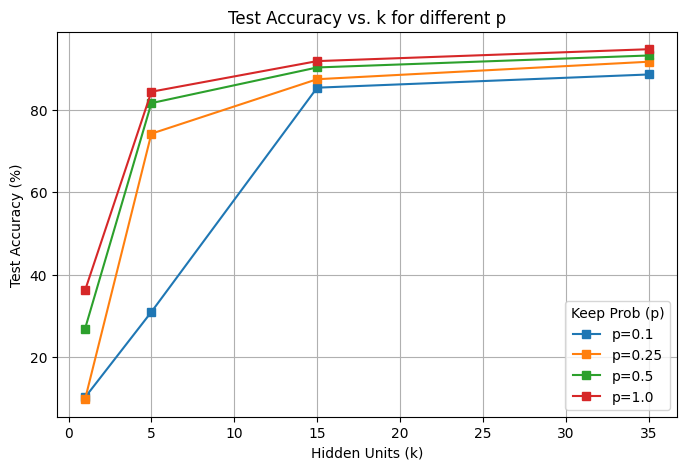

In [ ]:
import matplotlib.pyplot as plt

# Extract data for the plots
k_list = K_grid
p_list = P_grid

# 1. Plot for p=1.0 (No Dropout)
plt.figure(figsize=(8, 5))
train_p1 = [history[(k, 1.0)]['train_acc'] for k in k_list]
test_p1 = [history[(k, 1.0)]['test_acc'] for k in k_list]
plt.plot(k_list, train_p1, 'o-', label='Training Acc (p=1.0)')
plt.plot(k_list, test_p1, 's--', label='Test Acc (p=1.0)')
plt.title('Performance vs. Width (No Dropout: p=1.0)')
plt.xlabel('Hidden Units (k)')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)
plt.show()

# 2. Training Accuracy for all p
plt.figure(figsize=(8, 5))
for p in p_list:
    train_accs = [history[(k, p)]['train_acc'] for k in k_list]
    plt.plot(k_list, train_accs, 'o-', label=f'p={p}')
plt.title('Training Accuracy vs. k for different p')
plt.xlabel('Hidden Units (k)')
plt.ylabel('Training Accuracy (%)')
plt.legend(title="Keep Prob (p)")
plt.grid(True)
plt.show()

# 3. Test Accuracy for all p
plt.figure(figsize=(8, 5))
for p in p_list:
    test_accs = [history[(k, p)]['test_acc'] for k in k_list]
    plt.plot(k_list, test_accs, 's-', label=f'p={p}')
plt.title('Test Accuracy vs. k for different p')
plt.xlabel('Hidden Units (k)')
plt.ylabel('Test Accuracy (%)')
plt.legend(title="Keep Prob (p)")
plt.grid(True)
plt.show()

3. (7 pts) We will spice up the problem by adding some noise to labels. Pick 45% of the training examples
at random. Assign their labels at random to another value from 0 to 9. For instance, if the original
image is 0 and its label is 0, then you will assign its label to a number from 1 to 9 at random. Thus
55% of the training examples remain correct and 45% will have incorrect labels. Repeat the previous
step with this noisy dataset.

In [ ]:
import random

# Use the same subset indices
noisy_train_indices = get_balanced_subset_indices(full_train_dataset)
noisy_labels = {} # Map index to new noisy label

# 45% of 10,000 is 4,500
num_noisy = int(0.45 * len(noisy_train_indices))
indices_to_flip = random.sample(noisy_train_indices, num_noisy)

for idx in indices_to_flip:
    original_label = full_train_dataset.targets[idx].item()
    # Pick a random label that is NOT the original
    possible_labels = [i for i in range(10) if i != original_label]
    noisy_labels[idx] = random.choice(possible_labels)

# a custom Dataset wrapper to return the noisy labels
class NoisyMNIST(torch.utils.data.Dataset):
    def __init__(self, base_dataset, indices, noisy_map):
        self.base_dataset = base_dataset
        self.indices = indices
        self.noisy_map = noisy_map

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, i):
        original_idx = self.indices[i]
        img, _ = self.base_dataset[original_idx]

        # Return noisy label if it exists in our map, else return original
        label = self.noisy_map.get(original_idx, self.base_dataset.targets[original_idx].item())
        return img, label

# Create the new noisy loader
noisy_train_dataset = NoisyMNIST(full_train_dataset, noisy_train_indices, noisy_labels)
noisy_train_loader = DataLoader(noisy_train_dataset, batch_size=64, shuffle=True)

In [ ]:
history_noisy = {}

for k in K_grid:
    for p_val in P_grid:
        print(f"Training Noisy Model: k={k}, p_keep={p_val}...")
        torch_p = 1.0 - p_val
        model = ExperimentClassifier(k, torch_p)
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        criterion = nn.CrossEntropyLoss()

        for epoch in range(EPOCHS):
            model.train()
            for images, labels in noisy_train_loader:
                optimizer.zero_grad()
                loss = criterion(model(images), labels)
                loss.backward()
                optimizer.step()

        # Final evaluation
        model.eval()
        train_hits, test_hits = 0, 0
        with torch.no_grad():
            for img, lbl in noisy_train_loader:
                train_hits += (model(img).argmax(1) == lbl).sum().item()
            for img, lbl in test_loader:
                test_hits += (model(img).argmax(1) == lbl).sum().item()

        history_noisy[(k, p_val)] = {
            'train_acc': (train_hits / 10000) * 100,
            'test_acc': (test_hits / 10000) * 100
        }

Training Noisy Model: k=1, p_keep=0.1...
Training Noisy Model: k=1, p_keep=0.25...
Training Noisy Model: k=1, p_keep=0.5...
Training Noisy Model: k=1, p_keep=1.0...
Training Noisy Model: k=5, p_keep=0.1...
Training Noisy Model: k=5, p_keep=0.25...
Training Noisy Model: k=5, p_keep=0.5...
Training Noisy Model: k=5, p_keep=1.0...
Training Noisy Model: k=15, p_keep=0.1...
Training Noisy Model: k=15, p_keep=0.25...
Training Noisy Model: k=15, p_keep=0.5...
Training Noisy Model: k=15, p_keep=1.0...
Training Noisy Model: k=35, p_keep=0.1...
Training Noisy Model: k=35, p_keep=0.25...
Training Noisy Model: k=35, p_keep=0.5...
Training Noisy Model: k=35, p_keep=1.0...


4. (3 pts) Comment on the differences between Step 2 and Step 3. How does noise change things? For
which setup dropout is more useful?

In Step 2, the network uses its capacity (k) to learn the actual structure of digits.

In Step 3, the network learns the actual features of 55% correct data and memorize the arbitrary, random mappings of the 45% noisy data.

How noise changes things: I noticed that even with 45% noise, the training accuracy for k=35,p=1.0 still climbs toward 100%.



---

In step 2, dropout acts as a standard regularizer. It helps the model generalize slightly better, but even without it (p=1.0), the model performs well because the the labels are consistent with image features.

In step 3, dropout acts as a noise filter. By making zeros for neurons randomly, it prevent network to memorize the wrong label.

Dropout is more useful for the noisy setup. It makes network to reply on robust features shared by majority (55% correct labels) rather than the unique pixle-patterns of the mislabeled outliers.

In [1]:
!apt-get install texlive-xetex texlive-fonts-recommended texlive-plain-generic

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  dvisvgm fonts-droid-fallback fonts-lato fonts-lmodern fonts-noto-mono
  fonts-texgyre fonts-urw-base35 libapache-pom-java libcommons-logging-java
  libcommons-parent-java libfontbox-java libgs9 libgs9-common libidn12
  libijs-0.35 libjbig2dec0 libkpathsea6 libpdfbox-java libptexenc1 libruby3.0
  libsynctex2 libteckit0 libtexlua53 libtexluajit2 libwoff1 libzzip-0-13
  lmodern poppler-data preview-latex-style rake ruby ruby-net-telnet
  ruby-rubygems ruby-webrick ruby-xmlrpc ruby3.0 rubygems-integration t1utils
  teckit tex-common tex-gyre texlive-base texlive-binaries texlive-latex-base
  texlive-latex-extra texlive-latex-recommended texlive-pictures tipa
  xfonts-encodings xfonts-utils
Suggested packages:
  fonts-noto fonts-freefont-otf | fonts-freefont-ttf libavalon-framework-java
  libcommons-logging-java-doc libexcalibur-logkit-java 

In [2]:
!jupyter nbconvert --to pdf 'HW3_codes_thi_thi_khine.ipynb'

[NbConvertApp] WARNING | pattern 'HW3_codes_thi_thi_khine.ipynb' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalent to: [--JupyterApp.answer_yes=True]
-

In [3]:
!apt-get update

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:2 https://cli.github.com/packages stable InRelease [3,917 B]
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:4 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:6 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ Packages [83.8 kB]
Get:7 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:9 https://cli.github.com/packages stable/main amd64 Packages [356 B]
Get:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease [24.6 kB]
Get:11 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [9,682 kB]
Get:12 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:13 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,888 kB]
Get:14 http://security.u

In [4]:
!apt-get install -y texlive-xetex texlive-fonts-recommended texlive-plain-generic

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  dvisvgm fonts-droid-fallback fonts-lato fonts-lmodern fonts-noto-mono
  fonts-texgyre fonts-urw-base35 libapache-pom-java libcommons-logging-java
  libcommons-parent-java libfontbox-java libgs9 libgs9-common libidn12
  libijs-0.35 libjbig2dec0 libkpathsea6 libpdfbox-java libptexenc1 libruby3.0
  libsynctex2 libteckit0 libtexlua53 libtexluajit2 libwoff1 libzzip-0-13
  lmodern poppler-data preview-latex-style rake ruby ruby-net-telnet
  ruby-rubygems ruby-webrick ruby-xmlrpc ruby3.0 rubygems-integration t1utils
  teckit tex-common tex-gyre texlive-base texlive-binaries texlive-latex-base
  texlive-latex-extra texlive-latex-recommended texlive-pictures tipa
  xfonts-encodings xfonts-utils
Suggested packages:
  fonts-noto fonts-freefont-otf | fonts-freefont-ttf libavalon-framework-java
  libcommons-logging-java-doc libexcalibur-logkit-java 

In [9]:
!ls

sample_data


In [10]:
!jupyter nbconvert --to pdf '/HW3_codes_thi_thi_khine.ipynb'

[NbConvertApp] Converting notebook /HW3_codes_thi_thi_khine.ipynb to pdf
[NbConvertApp] Support files will be in HW3_codes_thi_thi_khine_files/
[NbConvertApp] Making directory ./HW3_codes_thi_thi_khine_files
[NbConvertApp] Writing 75771 bytes to notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', 'notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', 'notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 188571 bytes to /HW3_codes_thi_thi_khine.pdf
